Epoch [1/5], Train Loss: 0.2046, Train Accuracy: 94.34%, Val Loss: 0.0679, Val Accuracy: 97.64%
Precision: 0.9767, Recall: 0.9764, F1 Score: 0.9764
Epoch [2/5], Train Loss: 0.0631, Train Accuracy: 98.07%, Val Loss: 0.0492, Val Accuracy: 98.50%
Precision: 0.9851, Recall: 0.9850, F1 Score: 0.9850
Epoch [3/5], Train Loss: 0.0437, Train Accuracy: 98.66%, Val Loss: 0.0446, Val Accuracy: 98.48%
Precision: 0.9849, Recall: 0.9848, F1 Score: 0.9848
Epoch [4/5], Train Loss: 0.0332, Train Accuracy: 99.01%, Val Loss: 0.0392, Val Accuracy: 98.81%
Precision: 0.9882, Recall: 0.9881, F1 Score: 0.9881
Epoch [5/5], Train Loss: 0.0265, Train Accuracy: 99.16%, Val Loss: 0.0359, Val Accuracy: 98.90%
Precision: 0.9890, Recall: 0.9890, F1 Score: 0.9890
Test Accuracy: 98.90%
Test Precision: 0.9890, Test Recall: 0.9890, Test F1 Score: 0.9890


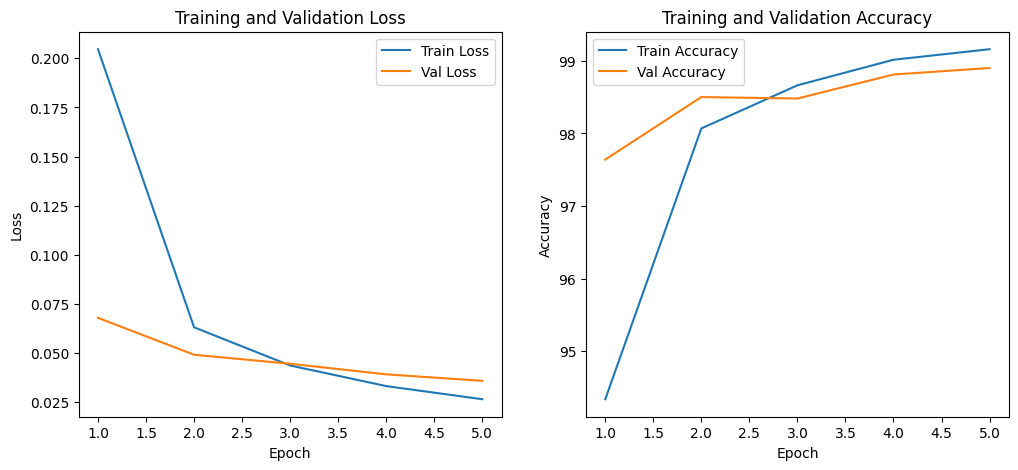

In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Hyperparameters
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 5  # Reduced epochs to 5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset (Training and Testing)
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.Compose([
                                               transforms.Resize((32, 32)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                           ]),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.Compose([
                                              transforms.Resize((32, 32)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                          ]),
                                          download=True)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# LeNet-5 Architecture with Tanh activation
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.Tanh(),  # Replaced ReLU with Tanh
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.Tanh(),  # Replaced ReLU with Tanh
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()  # Replaced ReLU with Tanh
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()  # Replaced ReLU with Tanh
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out

# Model, Loss, Optimizer
model = LeNet5(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training/validation metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_preds_train = []
    all_labels_train = []

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        all_preds_train.extend(predicted.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

    # Store training statistics
    epoch_loss_train = running_loss / len(train_loader)
    epoch_acc_train = 100 * correct_train / total_train
    train_losses.append(epoch_loss_train)
    train_accuracies.append(epoch_acc_train)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0.0
    all_preds_val = []
    all_labels_val = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            all_preds_val.extend(predicted.cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())

    # Store validation statistics
    epoch_loss_val = running_loss_val / len(test_loader)
    epoch_acc_val = 100 * correct_val / total_val
    val_losses.append(epoch_loss_val)
    val_accuracies.append(epoch_acc_val)

    # Print statistics after every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss_train:.4f}, Train Accuracy: {epoch_acc_train:.2f}%, '
          f'Val Loss: {epoch_loss_val:.4f}, Val Accuracy: {epoch_acc_val:.2f}%')

    # Print evaluation metrics (Precision, Recall, F1)
    precision = precision_score(all_labels_val, all_preds_val, average='weighted')
    recall = recall_score(all_labels_val, all_preds_val, average='weighted')
    f1 = f1_score(all_labels_val, all_preds_val, average='weighted')

    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Final evaluation on test data
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {test_accuracy:.2f}%')
    print(f'Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1:.4f}')

# Plot training and validation losses and accuracies
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Losses plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracies plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


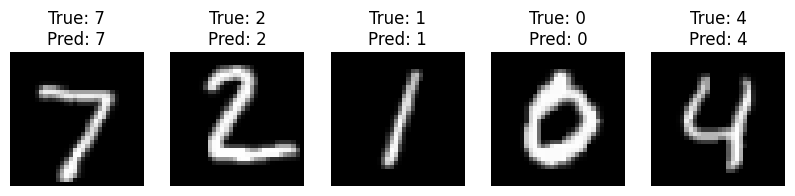

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to display images and predictions
def display_images_with_predictions(images, labels, predictions, num_images=3):
    fig = plt.figure(figsize=(10, 5))
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i + 1)
        image = images[i].squeeze()  # Remove channel dimension (for grayscale)
        ax.imshow(image, cmap='gray')

        true_label = labels[i].item()
        predicted_label = predictions[i].item()
        ax.set_title(f'True: {true_label}\nPred: {predicted_label}')
        ax.axis('off')
    plt.show()

# Now, let's load a few examples from the test dataset and make predictions.
model.eval()  # Set the model to evaluation mode (no gradient computation)
with torch.no_grad():
    # Grab a batch of images and labels from the test set
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions from the model
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Display the first few images with the predicted and true labels
    display_images_with_predictions(images.cpu(), labels.cpu(), predicted.cpu(), num_images=5)
